<a href="https://colab.research.google.com/github/tianshapojun/Transformer-for-vision-tasks/blob/main/Self_Supervised/dvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install git+https://github.com/openai/DALL-E.git

  Cloning https://github.com/openai/DALL-E.git to /tmp/pip-req-build-b65r_axd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/DALL-E.git /tmp/pip-req-build-b65r_axd
  Resolved https://github.com/openai/DALL-E.git to commit 5be4b236bc3ade6943662354117a0e83752cc322
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.0 MB/s eta 0:00:00
  Created wheel for DALL-E: filename=DALL_E-0.1-py3-none-any.whl size=5992 sha256=a837853a2b10ad3bd5044f566266635690072d2b16adc9d131ff624eb5cb810f
  Stored in directory: /tmp/pip-ephem-wheel-cache-d70osq0f/wheels/36/dd/cf/8a827e99dea9e6bd58430b95557c0a986bfbecd91a72ef8244
Successfully built DALL-E


In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    print(img.size)
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    print(img.size)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    print(img.size)
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    print(img.shape)
    return map_pixels(img)

In [ ]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cuda:0')

# For faster load times, download these files locally and use the local paths instead.
enc_old = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec_old = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

In [ ]:
from dall_e import Encoder, Decoder
enc = Encoder().to(dev)
enc.load_state_dict(enc_old.state_dict())
enc.eval()
dec = Decoder().to(dev)
dec.load_state_dict(dec_old.state_dict())
dec.eval()

Decoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=8192, n_out=128, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): DecoderBlock(
        (id_path): Conv2d(n_in=128, n_out=2048, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=128, n_out=512, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=512, n_out=2048, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): DecoderBlock(
    

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image
path = '/content/gdrive/MyDrive/Data/AdaNeRF/pavillon/train/00009.png'
im = Image.open(path)

(800, 800)
(256, 256)
(256, 256)
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


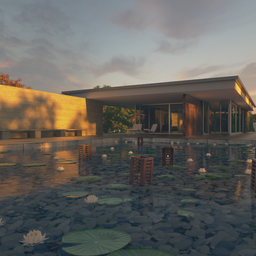

In [ ]:
#x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
x = preprocess(im)
print(x.shape)
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

Encoder
torch.Size([1, 8192, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 8192, 32, 32])
Decoder
torch.Size([1, 6, 256, 256])
torch.Size([1, 3, 256, 256])
(256, 256)


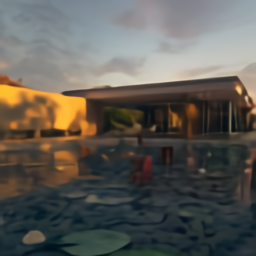

In [ ]:
import torch.nn.functional as F

print("Encoder")
z_logits = enc(x.cuda())
print(z_logits.shape)
z = torch.argmax(z_logits, axis=1)
print(z.shape)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
print(z.shape)

print("Decoder")
x_stats = dec(z).float()
print(x_stats.shape)
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
print(x_rec.shape)
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])
print(x_rec.size)
display_markdown('Reconstructed image:')
display(x_rec)